In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

from PIL import Image

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [48]:
# create a dataset and dataloader for the data
data_dir_train = '../data/SkinCancer/train/benign'

In [58]:
# Read 5 images from train dataset
ids = [3,4,6,17,12]
images_paths = [f'{data_dir_train}/{id}.jpg' for id in ids]
images = [np.array(Image.open(image_path)) for image_path in images_paths]

In [59]:
sam2_checkpoint = "../sam2/checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [60]:
# display the first image in the training set
first_image = images[0]
first_image.shape

(224, 224, 3)

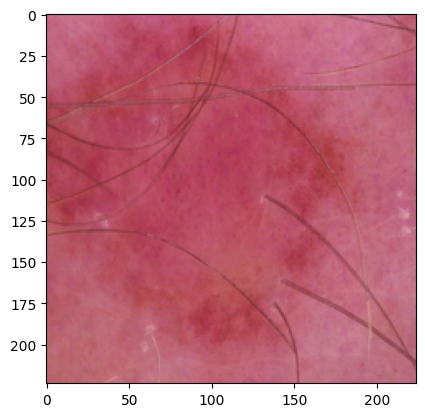

In [61]:
plt.imshow(first_image)

In [62]:
input_point = np.array([[112, 112]]) #center of the image
input_label = np.array([1]) # foreground point

masklist = []
scores_list = []

automasks_lists = []
autoscores_lists = []

for i in range(len(images)):
    predictor.set_image(images[i])
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    masklist.append(masks[0])
    scores_list.append(scores[0])

    #auto generated masks
    automasks, autoscores, autologits = predictor.predict(
        point_coords=None,
        point_labels=None,
        multimask_output=True,
    )
    sorted_ind = np.argsort(autoscores)[::-1]
    automasks = automasks[sorted_ind]
    autoscores = autoscores[sorted_ind]
    automasks_lists.append(automasks)
    autoscores_lists.append(autoscores)

In [65]:
autoscores_lists

[array([1.3035483e-07, 8.0107732e-08, 2.0011795e-08], dtype=float32),
 array([7.9766664e-08, 7.1763608e-08, 2.4684063e-10], dtype=float32),
 array([9.8193550e-07, 8.1529794e-07, 4.2713012e-07], dtype=float32),
 array([1.1285124e-07, 1.0915024e-07, 7.1221953e-09], dtype=float32),
 array([7.1829470e-07, 2.1943039e-07, 1.9943576e-07], dtype=float32)]

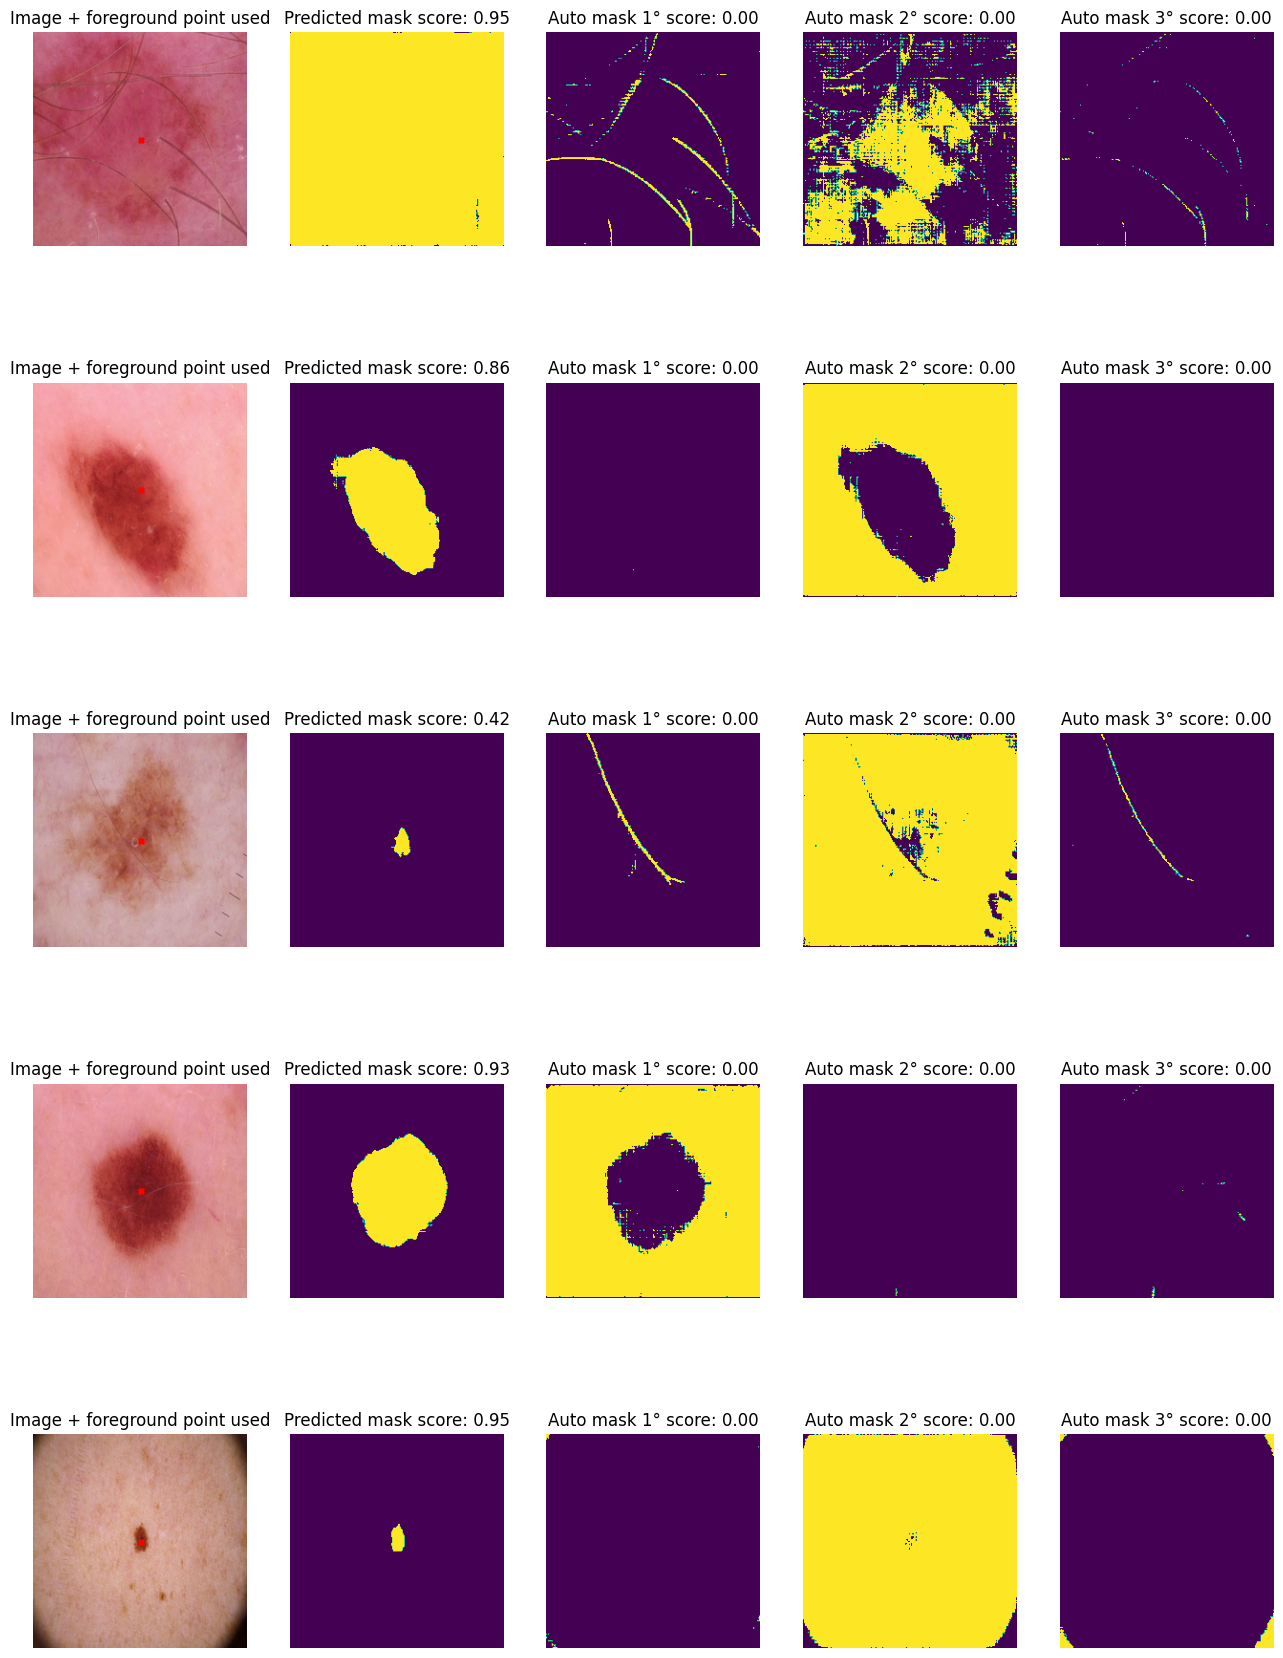

In [74]:
fig, ax = plt.subplots(5, 5, figsize=(16, 22))

for i in range(5):
    ax[i, 0].imshow(images[i])
    ax[i, 0].scatter(input_point[0, 0], input_point[0, 1], c="red", s=15, marker="X")
    ax[i, 0].set_title("Image + foreground point used")
    ax[i, 0].axis("off")

    ax[i, 1].imshow(masklist[i])
    ax[i, 1].set_title("Predicted mask score: {:.2f}".format(scores_list[i]))
    ax[i, 1].axis("off")

    ax[i, 2].imshow(automasks_lists[i][0])
    ax[i, 2].set_title("Auto mask 1° score: {:.2f}".format(autoscores_lists[i][0]))
    ax[i, 2].axis("off")

    ax[i, 3].imshow(automasks_lists[i][1])
    ax[i, 3].set_title("Auto mask 2° score: {:.2f}".format(autoscores_lists[i][1]))
    ax[i, 3].axis("off")

    ax[i, 4].imshow(automasks_lists[i][2])
    ax[i, 4].set_title("Auto mask 3° score: {:.2f}".format(autoscores_lists[i][2]))
    ax[i, 4].axis("off")